In [1]:
print("meowmeow")

print("hello?")

print("hehehaha")

meowmeow
hello?
hehehaha


In [3]:
print("kaiyi test")

print("weeeeeee")
print("weyuwuye")

kaiyi test
weeeeeee
weyuwuye


In [2]:
import cv2 
import os 
import numpy as np  # For numerical operations
from PIL import Image, ImageEnhance  # For image loading and augmentation
import matplotlib.pyplot as plt  # For visualization
from sklearn.preprocessing import LabelEncoder  # For encoding labels
import random  # For random transformations


In [3]:
from PIL import Image, ImageEnhance, ImageFilter

# Function to check if an image is too dark
def check_brightness(img):
    grayscale = img.convert("L")  # Convert to grayscale
    avg_brightness = np.mean(np.array(grayscale))  # Compute mean brightness
    return avg_brightness


def adjust_brightness(img):
    brightness = check_brightness(img)  # Get brightness value
    if brightness < 50:
        factor = 2.5  # Strong increase for very dark images
    elif brightness < 100:
        factor = 1.5  # Moderate increase for slightly dark images
    else:
        return img  # Skip enhancement if already bright

    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor)


# Function to resize image
def resize_image(img, target_size=(224, 224)):
    return img.resize(target_size, Image.LANCZOS)

# Function to sharpen image
def sharpen_image(img, radius=2, percent=200, threshold=3):
    return img.filter(ImageFilter.UnsharpMask(radius=radius, percent=percent, threshold=threshold))




In [6]:
# Loading dataset and preprocessing
train_folder = "Train" #change according to your file
target_size = (224, 224)

train_images = []
train_labels = []

for img_file in os.listdir(train_folder):
    if img_file.endswith(".png"):
        img_path = os.path.join(train_folder, img_file)

        # Load image using PIL
        img = Image.open(img_path).convert("RGB")

        # Extract class label from filename
        class_label = int(img_file.split("__")[0])

        # Apply preprocessing
        img = resize_image(img, target_size)  # Resize
        img = adjust_brightness(img)  # Adaptive Brightness Adjustment
        img = sharpen_image(img)  # Sharpen

        # Convert image to NumPy array and normalize
        img = np.array(img) / 255.0  

        # Store
        train_images.append(img)
        train_labels.append(class_label)

# Convert to NumPy arrays
X_train = np.array(train_images)
y_train = np.array(train_labels)

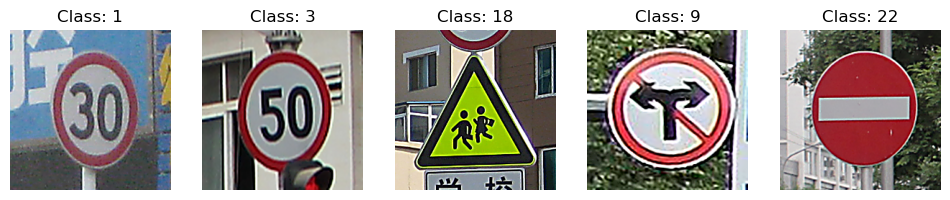

In [15]:
num_samples = 5  # Number of images to display
random_indices = random.sample(range(len(X_train)), num_samples)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_train[idx])  # Show image
    plt.title(f"Class: {y_train[idx]}")
    plt.axis("off")

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

#function for us to count the total number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [ ]:
#input_size = ??
#output_size = ??

class CNN(nn.Module):
    def __init__(self, input_size, n_features, output_size): #n_features = number of filters (feature maps)
        super(CNN, self).__init__()
        self.n_features = n_features
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_features, kernel_size=5) # input channel = 3 to allow for rgb image, update kernel size accordingly based on the input size
        self.conv2 = nn.Conv2d(n_features, n_features, kernel_size=5)
        self.fc1 = nn.Linear(n_features*4*4, 50)
        self.fc2 = nn.Linear(50, 10) #adjust input and output variables accordingly

    def forward(self, x):
        x = self.conv1(x) 
        x = F.relu(x) #using relu activation fn
        x = F.max_pool2d(x, kernel_size=2) # to downside the output (IF NEEDED since we doubled it jn)
        x = self.conv2(x) 
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4) #flattens the multi-dimensional output from the convolutional and pooling layers into a 1D vector to feed into fc layers
        x = self.fc1(x) #fully connected layers at the end
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1) #apply log soft max to the output

